# Multiple Quantum Wells and Finite Superlattices

This notebook processes the results generated by next**nano**++ for the simulation of finite superlattices, as outlined in Paul Harrison's book [Quantum Wells, Wires and Dots (2nd e.d)](https://www.wiley.com/en-us/Quantum+Wells%2C+Wires+and+Dots%3A+Theoretical+and+Computational+Physics+of+Semiconductor+Nanostructures%2C+4th+Edition-p-9781118923368). The section refered to is titled "Multiple Quantum Wells and Finite Superlattices" (Section 3.10, pp. 95-96)

In that section, $N$ repeats of 40Å GaAs / 40Å Ga<sub>0.8</sub>Al<sub>0.2</sub>As sandwiched between 200Å Ga<sub>0.8</sub>Al<sub>0.2</sub>As on the left and right. We will designate the coordinate $x=0$ as the start of the first well.

## nextnanopy features covered
This tutorial covers the following features of <code>nextnanopy</code>:
* Setting up and executing a sweeping variable
* Navgating the <code>DataFolder</code> output class to obtain the necessary values for plotting
* Plotting graphs with matplotlib
* Replacing a variable's value in an input file

## Python libraries used

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nextnanopy as nn
import os
import re
%matplotlib inline

## Checking the configuration of nextnanopy

The path directories in the config file must be set up. If they are not, refer to the [tutorial on setting up config files](https://github.com/nextnanopy/nextnanopy/blob/master/docs/examples/Example0_Set_up_the_configuration.ipynb).

In [2]:
software = 'nextnano++'
nn.config.config[software]

{'exe': 'C:\\Program Files\\nextnano\\2021_12_24\\nextnano++\\bin 64bit\\nextnano++_Intel_64bit.exe',
 'license': 'C:\\Users\\brandon.loke\\Documents\\nextnano\\License\\License_nnp.lic',
 'database': 'C:\\Program Files\\nextnano\\2021_12_24\\nextnano++\\Syntax\\database_nnp.in',
 'outputdirectory': 'D:\\nextnano output',
 'threads': 0}

We want to obtain all the paths, so we set up a simple function to aid us.

In [3]:
def get_directories(software):
    try:
        return nn.config.config[software]
    except:
        raise KeyError(f'Software name not recognised. Please choose one of: {list(nn.config.config.keys())}')

exe, license, database, output_folder, threads = list(get_directories('nextnano++').values())

## Setting up the sweeping variable

We will sweep through the variables using <code>nextnanopy</code>. We define
* The input folder
* The filename
* The variable of interest
* The values to be swept over. In this case, we want to simulate $2\leq N \leq 10$ wells

We will utilise <code>nextnanopy</code>'s <code>Sweep</code> class to aid in the sweeping of variables.

In [4]:
input_folder = r'D:\nextnano tutorials\1DSuperlattice_N_Wells'
filename = r'Superlattice_N_Wells.in'
filepath = os.path.join(input_folder, filename)
SweepVariable = 'NUMBER_OF_WELLS'
SweepValues = np.arange(2,11,1)

SweepingVariables = {SweepVariable: SweepValues}
#We can always increase the size of the dictionary if we have
#more variables we want to sweep over.

In [5]:
sweep = nn.Sweep(SweepingVariables, filepath)
print(sweep)

Sweep
fullpath: D:\nextnano tutorials\1DSuperlattice_N_Wells\Superlattice_N_Wells.in
Input variables: 10 elements
	$TEMPERATURE = 300 # Temperature (DisplayUnit:K)(ListOfValues:270, 280, 290, 300, 310, 320, 330)
	$WELL_WIDTH = 4.0 # Width of the quantum well (DisplayUnit:nm)(HighlightInUserInterface)(ListOfValues:5.0, 6.0, 7.0, 8.0, 9.0)  (RangeOfValues:From=5.0,To=9.0,Step=1.0)
	$BARRIER_WIDTH = 4.0 # Width of the barrier      (DisplayUnit:nm)(HighlightInUserInterface)(ListOfValues:7.0, 8.0, 9.0, 10.0, 11.0)(RangeOfValues:From=57.0,To=11.0,Step=1.0)
	$NUMBER_OF_WELLS = 4 # number of quantum wells   (DisplayUnit:)(HighlightInUserInterface)(ListOfValues:2, 3, 4, 5, 6, 7, 8, 9, 10)(RangeOfValues:From=2,To=10,Step=1)
	$SUPERLATTICE_WIDTH = $NUMBER_OF_WELLS * ( $BARRIER_WIDTH + $WELL_WIDTH ) - $BARRIER_WIDTH # (DisplayUnit:nm)(DoNotShowInUserInterface)
	$LEFT_BARRIER_WIDTH = 20 # Width of the Separate Confinement Heterostructure (SCH) (on the left) (DisplayUnit:nm)
	$RIGHT_BARRIER_WIDTH = 

In [6]:
sweep.save_sweep()

### Alternative way of getting the list of values
In next**nano**++, some variables already have a list of values or a range of values set up. This can be grabbed from the raw input file with the following functions

In [7]:
def grab_list_variables(input_file, VariableName):
    c = input_file.variables[VariableName].comment
    try:
        return np.array(list(map(float, re.search(r'(ListOfValues:)(.*?)\)', c).group(2).split(','))))
    except:
            raise ValueError("No list of values found for variable in input file. Check that variable has ListOfValues in comment or manually create a list of values.")
            
def grab_range_variables(input_file, VariableName):
    c = input_file.variables[VariableName].comment
    try:
        return np.array(list(map(float, re.search(r'(RangeOfValues:)(.*?)\)', c).group(2).split(','))))
    except:
            raise ValueError("No range of values found for variable in input file. Check that variable has RangeOfValues in comment or manually create a list of values.")     

For example, if we wanted to get the default list of values for the <code>$NUMBER_OF_WELLS</code> variable in next**nano**++, we may do the following.

In [8]:
input_file = nn.InputFile(filepath)

In [9]:
grab_list_variables(input_file, "NUMBER_OF_WELLS")

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

We will now execute the input file with the list of variables

In [10]:
sweep.execute_sweep()

STARTING...
Starting execution as:
C:\Program Files\nextnano\2021_12_24\nextnano++\bin 64bit\nextnano++_Intel_64bit.exe --license C:\Users\brandon.loke\Documents\nextnano\License\License_nnp.lic --database C:\Program Files\nextnano\2021_12_24\nextnano++\Syntax\database_nnp.in --threads 0 --outputdirectory D:\nextnano output\Superlattice_N_Wells_sweep__NUMBER_OF_WELLS\Superlattice_N_Wells__NUMBER_OF_WELLS_2_ --noautooutdir D:\nextnano tutorials\1DSuperlattice_N_Wells\Superlattice_N_Wells__NUMBER_OF_WELLS_2_.in 

nextnano++ (1.9.3 - 2021.122001) Jan 25 2022
COPYRIGHT NOTICE                                                             
Please read the file 'copyright_nextnano++.txt' in your installation folder  
for further information about the terms of copyright of the nextnano++ code  
and of third party source codes and libraries used in the nextnano++ code.   
                                                                             
In case this file is missing or seems incomplete

  valence band maximum: -0.794876818
  conduction band minimum: 0.627605325

 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1          70
      
 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1         250
      
 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1          70
      
 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1         100
      

Computing densities...

QUANTUM-CURRENT-POISSON:   Residual_EDensity = 6.697189500


Material database initialized.

Checking license:
	 Valid From: 2022-1-1 To: 2022-12-31
	 Licensed to: E-mail: brandon.loke@nextnano.com-2022-12-31-de-0000-00-nxt3

********* SETUP SIMULATION *****************************************************

NOTE: Using output directory specified from command line (nextnanomat), 

NOTE: Setting output directory to: D:\nextnano output\Superlattice_N_Wells_sweep__NUMBER_OF_WELLS\Superlattice_N_Wells__NUMBER_OF_WELLS_3_\

********* Simulation Grid *********

Creating grid 1 using:
    pos = -21     	spacing = 1
    pos = -20     	spacing = 0.1
    pos = 40     	spacing = 0.1
    pos = 41     	spacing = 0.1

Grid dimension: 612 * 1 * 1 
Number of unique grid points: 612
Range in 1-direction:   -21 , ... , 41


********* Rotation Matrix *********
 1.0000000,  0.0000000,  0.0000000
 0.0000000,  1.0000000,  0.0000000
 0.0000000,  0.0000000,  1.0000000

********* Periodicity *************
  0-direction:  not periodic


Start initializing structure.
Finis

      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         532         601
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         502         601
      

Computing densities...

QUANTUM-CURRENT-POISSON:   Residual_EDensity = 4.725720942e-13      Residual_HDensity = 7.354396530e-14
QUANTUM-CURRENT-POISSON:   Residual_EFermilevel = 0.000000000e+00   Residual_HFermilevel = 0.000000000e+00
QUANTUM-CURRENT-POISSON:   Residual_Potential = 0.000000000e+00

*----  SOLVING QUANTUM-CURRENT-POISSON EQUATIONS FINISHED ----------------------------

Calculating classical integrated carrier densities as function of energy.

Calculating quantum integrated carrier densities as function of energy.

Calculating classical energy-resolved carrier densities.

Calculating quantum energy-resolved carrier densities.

Solving Quantum Mechanics ---- (quantum regions without density only)


Solving 

  Newton step: 1	1.541720510200749e-12
  Newton achieved/desired residual: 1.51049037e-12 1.80951265e-10

Solving Quantum Mechanics ---- (and calculate density)

  valence band maximum: -0.794876818
  conduction band minimum: 0.627605325

 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1          70
      
 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1         250
      
 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1          70
      
 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver).


Material database initialized.

Checking license:
	 Valid From: 2022-1-1 To: 2022-12-31
	 Licensed to: E-mail: brandon.loke@nextnano.com-2022-12-31-de-0000-00-nxt3

********* SETUP SIMULATION *****************************************************

NOTE: Using output directory specified from command line (nextnanomat), 

NOTE: Setting output directory to: D:\nextnano output\Superlattice_N_Wells_sweep__NUMBER_OF_WELLS\Superlattice_N_Wells__NUMBER_OF_WELLS_5_\

********* Simulation Grid *********

Creating grid 1 using:
    pos = -21     	spacing = 1
    pos = -20     	spacing = 0.1
    pos = 56     	spacing = 0.1
    pos = 57     	spacing = 0.1

Grid dimension: 772 * 1 * 1 
Number of unique grid points: 772
Range in 1-direction:   -21 , ... , 57


********* Rotation Matrix *********
 1.0000000,  0.0000000,  0.0000000
 0.0000000,  1.0000000,  0.0000000
 0.0000000,  0.0000000,  1.0000000

********* Periodicity *************
  0-direction:  not periodic


Start initializing structure.
Finis

  Newton achieved/desired residual: 1.4881637e-12 1.80951265e-10

Solving Quantum Mechanics ---- (and calculate density)

  valence band maximum: -0.794876818
  conduction band minimum: 0.627605325

 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:           1          70
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         512         761
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         692         761
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         662         761
      

Computing densities...

QUANTUM-CURRENT-POISSON:   Residual_EDensity = 1.158062927e-12      Residual_HDensity = 6.175286366e-14
QUANTUM-CURRENT-POISSON:   Residual_EFermilevel = 0.000000000e+00   Residual_HFermilevel = 0.000000000e+00
QUANTUM-CURRENT-POISSON:   Residual_Poten

 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         742         841
      

Computing densities...

******  SOLVING QUANTUM-CURRENT-POISSON EQUATIONS *----------------------------
*----  Terminates after:   max_iter = 1000
                        residual =       1.000000000e+06[carriers/cm^2]
                        residual_fermi = 1.000000000e-08
Set Fermi level range: -0 -0

QUANTUM-CURRENT-POISSON:  iteration = 1 of 1000 ----------------------------

Current-repetition:   iteration = 1 of 2 -------------

Calculating electron mobility...
Calculating hole mobility...
Calculating variable recombination and generation...
Calculating fixed generation/recombination/injection...

Solving electron current equation(s)...

Solving hole current equation(s)...

Computing densities...

Current-Density:   Residual_EFermilevel = 0.000000000e+00   Residual_HFermilevel = 0.000000000e+00

Current-repetition:   iteration = 2 of 2 -------------


Material database initialized.

Checking license:
	 Valid From: 2022-1-1 To: 2022-12-31
	 Licensed to: E-mail: brandon.loke@nextnano.com-2022-12-31-de-0000-00-nxt3

********* SETUP SIMULATION *****************************************************

NOTE: Using output directory specified from command line (nextnanomat), 

NOTE: Setting output directory to: D:\nextnano output\Superlattice_N_Wells_sweep__NUMBER_OF_WELLS\Superlattice_N_Wells__NUMBER_OF_WELLS_7_\

********* Simulation Grid *********

Creating grid 1 using:
    pos = -21     	spacing = 1
    pos = -20     	spacing = 0.1
    pos = 72     	spacing = 0.1
    pos = 73     	spacing = 0.1

Grid dimension: 932 * 1 * 1 
Number of unique grid points: 932
Range in 1-direction:   -21 , ... , 73


********* Rotation Matrix *********
 1.0000000,  0.0000000,  0.0000000
 0.0000000,  1.0000000,  0.0000000
 0.0000000,  0.0000000,  1.0000000

********* Periodicity *************
  0-direction:  not periodic


Start initializing structure.
Finis

  Newton achieved/desired residual: 1.74306238e-12 1.80951265e-10

Solving Quantum Mechanics ---- (and calculate density)

  valence band maximum: -0.794876818
  conduction band minimum: 0.627605325

 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:           1          70
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         672         921
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         852         921
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         822         921
      

Computing densities...

QUANTUM-CURRENT-POISSON:   Residual_EDensity = 1.038767264e-12      Residual_HDensity = 9.732498233e-14
QUANTUM-CURRENT-POISSON:   Residual_EFermilevel = 0.000000000e+00   Residual_HFermilevel = 0.000000000e+00
QUANTUM-CURRENT-POISSON:   Residual_Pote

      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         932        1001
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         902        1001
      

Computing densities...

******  SOLVING QUANTUM-CURRENT-POISSON EQUATIONS *----------------------------
*----  Terminates after:   max_iter = 1000
                        residual =       1.000000000e+06[carriers/cm^2]
                        residual_fermi = 1.000000000e-08
Set Fermi level range: -0 -0

QUANTUM-CURRENT-POISSON:  iteration = 1 of 1000 ----------------------------

Current-repetition:   iteration = 1 of 2 -------------

Calculating electron mobility...
Calculating hole mobility...
Calculating variable recombination and generation...
Calculating fixed generation/recombination/injection...

Solving electron current equation(s)...

Solving hole current equation(s)...

Computing densities...

Current-Density:


Material database initialized.

Checking license:
	 Valid From: 2022-1-1 To: 2022-12-31
	 Licensed to: E-mail: brandon.loke@nextnano.com-2022-12-31-de-0000-00-nxt3

********* SETUP SIMULATION *****************************************************

NOTE: Using output directory specified from command line (nextnanomat), 

NOTE: Setting output directory to: D:\nextnano output\Superlattice_N_Wells_sweep__NUMBER_OF_WELLS\Superlattice_N_Wells__NUMBER_OF_WELLS_9_\

********* Simulation Grid *********

Creating grid 1 using:
    pos = -21     	spacing = 1
    pos = -20     	spacing = 0.1
    pos = 88     	spacing = 0.1
    pos = 89     	spacing = 0.1

Grid dimension: 1092 * 1 * 1 
Number of unique grid points: 1092
Range in 1-direction:   -21 , ... , 89


********* Rotation Matrix *********
 1.0000000,  0.0000000,  0.0000000
 0.0000000,  1.0000000,  0.0000000
 0.0000000,  0.0000000,  1.0000000

********* Periodicity *************
  0-direction:  not periodic


Start initializing structure.
Fin

  Newton achieved/desired residual: 1.94540056e-12 1.80951265e-10

Solving Quantum Mechanics ---- (and calculate density)

  valence band maximum: -0.794876818
  conduction band minimum: 0.627605325

 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:           1          70
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         832        1081
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:        1012        1081
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:         982        1081
      

Computing densities...

QUANTUM-CURRENT-POISSON:   Residual_EDensity = 7.274679208e-13      Residual_HDensity = 1.690708802e-13
QUANTUM-CURRENT-POISSON:   Residual_EFermilevel = 0.000000000e+00   Residual_HFermilevel = 0.000000000e+00
QUANTUM-CURRENT-POISSON:   Residual_Pote

      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:        1092        1161
      
 Solving 1 exact 1-band Schroedinger equation(s):
    Tridiagonal real symmetric eigenvalue solver:        1062        1161
      

Computing densities...

******  SOLVING QUANTUM-CURRENT-POISSON EQUATIONS *----------------------------
*----  Terminates after:   max_iter = 1000
                        residual =       1.000000000e+06[carriers/cm^2]
                        residual_fermi = 1.000000000e-08
Set Fermi level range: -0 -0

QUANTUM-CURRENT-POISSON:  iteration = 1 of 1000 ----------------------------

Current-repetition:   iteration = 1 of 2 -------------

Calculating electron mobility...
Calculating hole mobility...
Calculating variable recombination and generation...
Calculating fixed generation/recombination/injection...

Solving electron current equation(s)...

Solving hole current equation(s)...

Computing densities...

Current-Density:

We can obtain the output directory of the results and use the <code>DataFile</code> class to navigate its structure

In [11]:
sweep.sweep_output_directory

'D:\\nextnano output\\Superlattice_N_Wells_sweep__NUMBER_OF_WELLS'

In [12]:
sweepFolder = nn.DataFolder(sweep.sweep_output_directory)

In [13]:
sweepFolder.show_tree()

Superlattice_N_Wells_sweep__NUMBER_OF_WELLS/
    Superlattice_N_Wells__NUMBER_OF_WELLS_10_/
        bias_00000/
            Optical/
                computed_absorption_spectrum_cm-1.dat
                computed_absorption_spectrum_eV.dat
                computed_absorption_spectrum_nm.dat
                computed_absorption_spectrum_THz.dat
                computed_gain_spectrum_cm-1.dat
                computed_gain_spectrum_eV.dat
                computed_gain_spectrum_nm.dat
                computed_gain_spectrum_THz.dat
                computed_imepsilon_spectrum_cm-1.dat
                computed_imepsilon_spectrum_eV.dat
                computed_imepsilon_spectrum_nm.dat
                computed_imepsilon_spectrum_THz.dat
                emission_photon_density.dat
                emission_power_density.dat
                emission_spectrum_photons_cm-1.dat
                emission_spectrum_photons_eV.dat
                emission_spectrum_photons_nm.dat
                emission_s

## Plotting the $\Gamma$ band edges

We obtain the x coordinates and the gamma bandedge values with the following lines

In [14]:
x = nn.DataFile(sweepFolder.go_to('Superlattice_N_Wells__NUMBER_OF_WELLS_2_', 'bias_00000', 'bandedges.dat'), product = software).coords['x'].value
gamma = nn.DataFile(sweepFolder.go_to('Superlattice_N_Wells__NUMBER_OF_WELLS_2_', 'bias_00000', 'bandedges.dat'), product = software).variables['Gamma'].value

Before we plot the $\Gamma$ energies against $x$, we check that the dimensions are identical

In [15]:
np.size(x) == np.size(gamma)

True

In [16]:
palette = ['#343131','#13adb5']
plt.style.use('default')
plt.style.use('seaborn-deep')

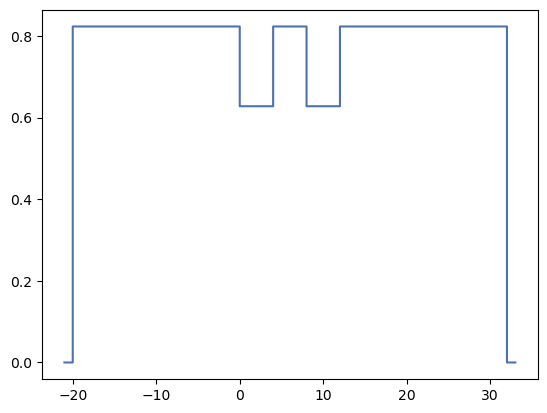

In [17]:
fig, ax = plt.subplots()
ax.plot(x, gamma)

## Recreating Harrison's Figures
Harrison's figures take the bottom of the quantum well to be at 0 potential. Differences in how next**nano**++ calculates the band edges result in a different offset in the values outputted by the software.

We will first obtain the offset with

In [18]:
bandedgeoffset = np.amin(gamma[30:-30]) #Values chosen to avoid the 0 value at the start and end
bandedgeoffset

0.62760532478571

If the offset is known before hand, one can use <code>numpy</code> array manipulation to apply a function on the array

In [19]:
gamma_shift = gamma - bandedgeoffset

### Finding groundstate energies

To find the groundstate energies as a function of the number of wells, we will create a simple function to iterate over all the $N$ wells. The groundstate energies are found in the <code>Quantum</code> subfolder. We first demonstrate how to obtain the groundstate energies for the $N=2$ case and then a way to get the groundstate energies for all $N$ values

In [20]:
nn.DataFile(sweepFolder.go_to('Superlattice_N_Wells__NUMBER_OF_WELLS_2_', 
                                 'bias_00000', 'Quantum','amplitudes_shift_quantum_region_Gamma_00000.dat'), 
                                    product = software).variables['E_1'].value

array([0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804778,
       0.70804778, 0.70804778, 0.70804778, 0.70804778, 0.70804

Every different value of $N$ outputs a different output folder. We have to iterate through the folders to obtain the groundstate energies.

In [21]:
def is_dir(file):
    p = os.path.join(sweep.sweep_output_directory,file)
    return os.path.isdir(p)
    
sweepFiles = list(filter(is_dir, os.listdir(sweep.sweep_output_directory)))
sweepFiles

['Superlattice_N_Wells__NUMBER_OF_WELLS_10_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_2_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_3_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_4_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_5_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_6_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_7_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_8_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_9_']

We observe that the value 10 is at the start of the list. We would like this to be at the end of the list

In [22]:
sweepFiles = sweepFiles[1:] + [sweepFiles[0]]
sweepFiles

['Superlattice_N_Wells__NUMBER_OF_WELLS_2_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_3_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_4_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_5_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_6_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_7_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_8_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_9_',
 'Superlattice_N_Wells__NUMBER_OF_WELLS_10_']

We now want to store the first eigenstate energies into a single array so that it can be plotted alongside the number of wells. We can obtain all the energies with a simple function.

In [23]:
def get_all_energies(sweepFiles):
    arr = np.array([])
    for file in sweepFiles:
        energy = (nn.DataFile(sweepFolder.go_to(file, 
                                 'bias_00000', 'Quantum','amplitudes_shift_quantum_region_Gamma_00000.dat'), 
                                    product = software).variables['E_1'].value - bandedgeoffset) * 1000
        ##we shift the values downwards by the bandedgeoffset
        ##we also multiply by 1000 to convert from eV to meV
        single_value = np.amin(energy)
        arr = np.append(arr, single_value)
    return arr

groundstate_energies = get_all_energies(sweepFiles)
groundstate_energies

array([80.44245385, 77.86580546, 76.64523122, 75.97516064, 75.56880168,
       75.30413953, 75.1222754 , 74.99198527, 74.89547682])

Text(0.5, 1.0, 'Ground state energies')

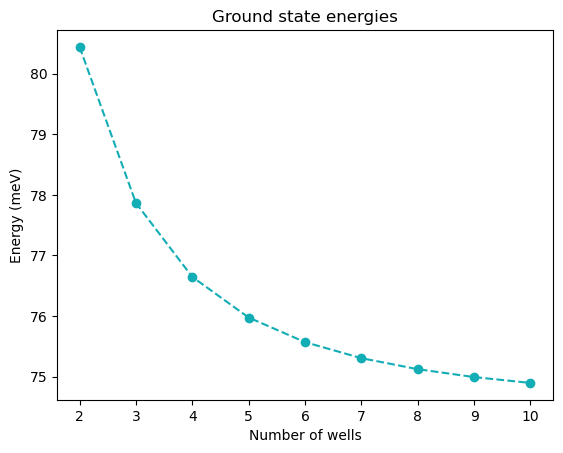

In [24]:
fig, ax = plt.subplots()
ax.plot(SweepValues, groundstate_energies, 'o--', color = palette[1])
# ax.grid(visible = True)
ax.set_ylabel('Energy (meV)')
ax.set_xlabel('Number of wells')
ax.set_title('Ground state energies')

# plt.savefig('./Images/EnergyVsN.png', dpi = 2000)

### Wavefunction in a finite superlattice
The first case has the following parameters:
* 40Å GaAs / 40Å Ga<sub>0.8</sub>Al<sub>0.2</sub>As sandwiched between 200Å Ga<sub>0.8</sub>Al<sub>0.2</sub>As on the left and right.
* 10 wells
* 4nm quantum wells
* 4nm barriers

**Getting the wavefunction and the x coordinates** <br>
We only want the groundstate wavefunction amplitudes.

Note that we cannot use the x-coordinates found in <code>bandedges.dat</code> for <code>amplitudes_shift_quantum_region_Gamma_00000.dat</code> because the dimensions of the array are not equal. We therefore have to plot the following pairs:
* Amplitude of the wavefunction and its corresponding x coordinates
* Bandedge and its corresponding x coordinates

In [25]:
wf1 = (nn.DataFile(sweepFolder.go_to(sweepFiles[-1], 
         'bias_00000', 'Quantum','amplitudes_shift_quantum_region_Gamma_00000.dat'), 
            product = software).variables['Psi_1'].value - bandedgeoffset) * 1000

bandedge10 = (nn.DataFile(sweepFolder.go_to(sweepFiles[-1], 
         'bias_00000', 'bandedges.dat'), 
            product = software).variables['Gamma'].value - bandedgeoffset) * 1000

x = nn.DataFile(sweepFolder.go_to(sweepFiles[-1], 
         'bias_00000', 'bandedges.dat'), 
            product = software).coords['x'].value

xwf1 = nn.DataFile(sweepFolder.go_to(sweepFiles[-1], 
         'bias_00000', 'Quantum','amplitudes_shift_quantum_region_Gamma_00000.dat'), 
            product = software).coords['x'].value

Text(0.5, 1.0, 'Finite Superlattice')

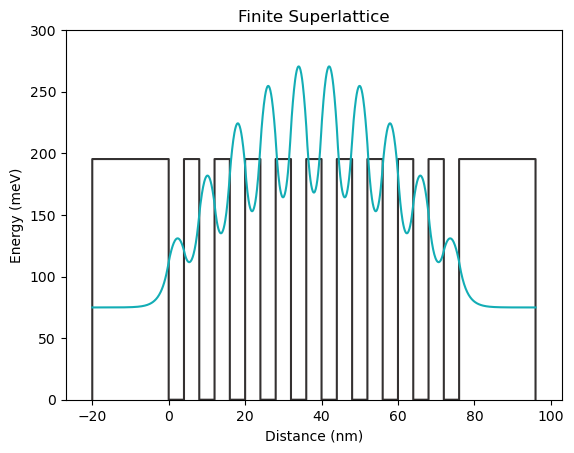

In [26]:
fig, ax = plt.subplots()
ax.plot(x, bandedge10, color = palette[0])
ax.plot(xwf1, wf1, color = palette[1])

ax.set_ylim(0,300)
ax.set_xlabel('Distance (nm)')
ax.set_ylabel('Energy (meV)')
ax.set_title('Finite Superlattice')

# plt.savefig('./Images/wf1.png', dpi = 2000)

### Wavefunction in a multiple quantum well system

The second case plotted has the following parameters:
* 100Å GaAs / 100Å Ga<sub>0.6</sub>Al<sub>0.4</sub>As sandwiched between 100Å Ga<sub>0.6</sub>Al<sub>0.4</sub>As on the left and right.
* 4 wells
* 10nm quantum wells
* 10nm barriers

Note that Ga<sub>x</sub>Al<sub>1-x</sub>As used here is different from the earlier graph plotted.

The alloy composition and the thickness of the barriers and the quantum wells are different in this example. We will use nextnanopy to change the variables and output the result.

In [27]:
input_file.fullpath

'D:\\nextnano tutorials\\1DSuperlattice_N_Wells\\Superlattice_N_Wells.in'

In [28]:
input_file.variables.keys()

odict_keys(['TEMPERATURE', 'WELL_WIDTH', 'BARRIER_WIDTH', 'NUMBER_OF_WELLS', 'SUPERLATTICE_WIDTH', 'LEFT_BARRIER_WIDTH', 'RIGHT_BARRIER_WIDTH', 'FINE_GRID_SPACING', 'COARSE_GRID_SPACING', 'ALLOY_X'])

We want to change
* <code>WELl_WIDTH</code>
* <code>BARRIER_WIDTH</code>
* <code>LEFT_BARRIER_WIDTH</code>
* <code>RIGHT_BARRIER_WIDTH</code>
* <code>NUMBER_OF_WELLS</code>

In addition to this, we will save this new input file into the output folder.

In [29]:
input_file.set_variable(name = "WELL_WIDTH", value = 10)
input_file.set_variable(name = "BARRIER_WIDTH", value = 10)
input_file.set_variable(name = "LEFT_BARRIER_WIDTH" , value = 10)
input_file.set_variable(name = "RIGHT_BARRIER_WIDTH" , value = 10)
input_file.set_variable(name = "NUMBER_OF_WELLS", value = 4)


my_input_file_new = os.path.join(output_folder, r'Superlattice_N_Wells_WF2' + ".in")
input_file.save(my_input_file_new, overwrite = True, automkdir = True)

'D:\\nextnano output\\Superlattice_N_Wells_WF2.in'

We now create a function to run the input file and ouput the result

In [30]:
input_file.execute()

STARTING...
Starting execution as:
C:\Program Files\nextnano\2021_12_24\nextnano++\bin 64bit\nextnano++_Intel_64bit.exe --license C:\Users\brandon.loke\Documents\nextnano\License\License_nnp.lic --database C:\Program Files\nextnano\2021_12_24\nextnano++\Syntax\database_nnp.in --threads 0 --outputdirectory D:\nextnano output\Superlattice_N_Wells_WF2 --noautooutdir D:\nextnano output\Superlattice_N_Wells_WF2.in 

nextnano++ (1.9.3 - 2021.122001) Jan 25 2022
COPYRIGHT NOTICE                                                             
Please read the file 'copyright_nextnano++.txt' in your installation folder  
for further information about the terms of copyright of the nextnano++ code  
and of third party source codes and libraries used in the nextnano++ code.   
                                                                             
In case this file is missing or seems incomplete or corrupted, please contact
nextnano GmbH, Germany by submitting a support request on www.nextnano.d

 Solving 1 approximate (subspace) 1-band Schroedinger equation(s):
   Solving dense hermitian eigenvalue problem (standard solver)...
      Full real symmetric eigenvalue solver:           1         100
      

Computing densities...

QUANTUM-CURRENT-POISSON:   Residual_EDensity = 3.777261323e-12      Residual_HDensity = 7.111816024e-14
QUANTUM-CURRENT-POISSON:   Residual_EFermilevel = 0.000000000e+00   Residual_HFermilevel = 0.000000000e+00
QUANTUM-CURRENT-POISSON:   Residual_Potential = 0.000000000e+00

QUANTUM-CURRENT-POISSON:  iteration = 2 of 1000 ----------------------------

Current-repetition:   iteration = 1 of 2 -------------

Calculating electron mobility...
Calculating hole mobility...
Calculating variable recombination and generation...
Calculating fixed generation/recombination/injection...

Solving electron current equation(s)...

Solving hole current equation(s)...

Computing densities...

Current-Density:   Residual_EFermilevel = 0.000000000e+00   Residual_HFermilevel 

{'process': <Popen: returncode: 0 args: '"C:\\Program Files\\nextnano\\2021_12_24\\nextn...>,
 'outputdirectory': 'D:\\nextnano output\\Superlattice_N_Wells_WF2',
 'filename': 'Superlattice_N_Wells_WF2',
 'logfile': 'D:\\nextnano output\\Superlattice_N_Wells_WF2\\Superlattice_N_Wells_WF2.log',
 'cmd': '"C:\\Program Files\\nextnano\\2021_12_24\\nextnano++\\bin 64bit\\nextnano++_Intel_64bit.exe" --license "C:\\Users\\brandon.loke\\Documents\\nextnano\\License\\License_nnp.lic" --database "C:\\Program Files\\nextnano\\2021_12_24\\nextnano++\\Syntax\\database_nnp.in" --threads 0 --outputdirectory "D:\\nextnano output\\Superlattice_N_Wells_WF2" --noautooutdir "D:\\nextnano output\\Superlattice_N_Wells_WF2.in"',
 'wdir': 'C:\\Program Files\\nextnano\\2021_12_24\\nextnano++\\bin 64bit'}

In [31]:
input_file.folder_output

'D:\\nextnano output\\Superlattice_N_Wells_WF2'

In [32]:
wf2Folder = nn.DataFolder(input_file.folder_output)

In [33]:
wf2Folder.show_tree()

Superlattice_N_Wells_WF2/
    bias_00000/
        Optical/
            computed_absorption_spectrum_cm-1.dat
            computed_absorption_spectrum_eV.dat
            computed_absorption_spectrum_nm.dat
            computed_absorption_spectrum_THz.dat
            computed_gain_spectrum_cm-1.dat
            computed_gain_spectrum_eV.dat
            computed_gain_spectrum_nm.dat
            computed_gain_spectrum_THz.dat
            computed_imepsilon_spectrum_cm-1.dat
            computed_imepsilon_spectrum_eV.dat
            computed_imepsilon_spectrum_nm.dat
            computed_imepsilon_spectrum_THz.dat
            emission_photon_density.dat
            emission_power_density.dat
            emission_spectrum_photons_cm-1.dat
            emission_spectrum_photons_eV.dat
            emission_spectrum_photons_nm.dat
            emission_spectrum_photons_THz.dat
            emission_spectrum_power_cm-1.dat
            emission_spectrum_power_eV.dat
            emission_spectrum_powe

We will take similar steps to the exercise above where we plotted the wavefunction. 

In [34]:
wf2 = (nn.DataFile(wf2Folder.go_to('bias_00000', 'Quantum', 
                                  'amplitudes_shift_quantum_region_Gamma_00000.dat'), product = software).variables['Psi_1'].value - bandedgeoffset) * 1000

bandedge = (nn.DataFile(wf2Folder.go_to('bias_00000', 'bandedges.dat'), product = software).variables['Gamma'].value - bandedgeoffset) * 1000

x = nn.DataFile(wf2Folder.go_to('bias_00000', 'bandedges.dat'), product = software).coords['x'].value

xwf2 = (nn.DataFile(wf2Folder.go_to('bias_00000', 'Quantum', 'amplitudes_shift_quantum_region_Gamma_00000.dat'), product = software).coords['x'].value)

**Plotting the figure**

Text(0.5, 1.0, 'Multiple Quantum Well')

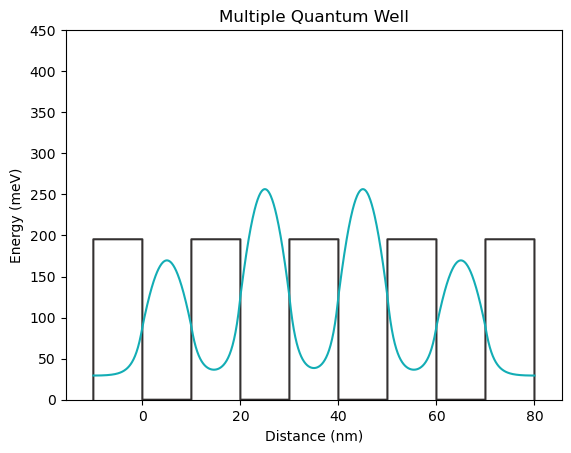

In [35]:
fig, ax = plt.subplots()
ax.plot(x, bandedge, color = palette[0])
ax.plot(xwf2, wf2, palette[1])

ax.set_ylim([0,450])
ax.set_xlabel('Distance (nm)')
ax.set_ylabel('Energy (meV)')
ax.set_title('Multiple Quantum Well')

# plt.savefig('./Images/wf2.png', dpi = 2000)